In [47]:
# Import Libraries
import requests
import pandas as pd
import numpy as np
import datetime

# SpaceX API URL
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
response_json = response.json()

# Convert API to DataFrame
data = pd.json_normalize(response_json)
data = data[['rocket','payloads','launchpad','cores','flight_number','date_utc']]

# API Helper Functions
def getBoosterVersion(data):
    BoosterVersion = []
    for x in data['rocket']:
        if x:
            r = requests.get(f"https://api.spacexdata.com/v4/rockets/{x}").json()
            BoosterVersion.append(r['name'])
    return BoosterVersion

def getLaunchSite(data):
    LaunchSite, Longitude, Latitude = [], [], []
    for x in data['launchpad']:
        if x:
            r = requests.get(f"https://api.spacexdata.com/v4/launchpads/{x}").json()
            LaunchSite.append(r['name'])
            Longitude.append(r['longitude'])
            Latitude.append(r['latitude'])
    return LaunchSite, Longitude, Latitude

def getPayloadData(data):
    PayloadMass, Orbit = [], []
    for x in data['payloads']:
        if x:
            r = requests.get(f"https://api.spacexdata.com/v4/payloads/{x[0]}").json()
            PayloadMass.append(r.get('mass_kg', np.nan))
            Orbit.append(r.get('orbit'))
    return PayloadMass, Orbit

def getCoreData(data):
    Outcome, Reused, GridFins, Legs, Block, ReusedCount = [], [], [], [], [], []
    for c in data['cores']:
        if c[0]['core'] is not None:
            core = requests.get(f"https://api.spacexdata.com/v4/cores/{c[0]['core']}").json()
            Outcome.append(str(c[0]['landing_success']) + " " + str(c[0]['landing_type']))
            Reused.append(c[0]['reused'])
            GridFins.append(c[0]['gridfins'])
            Legs.append(c[0]['legs'])
            Block.append(core.get('block'))
            ReusedCount.append(core.get('reuse_count'))
        else:
            Outcome.append(None)
            Reused.append(None)
            Block.append(None)
            ReusedCount.append(None)
    return Outcome, Reused, GridFins, Legs, Block, ReusedCount

# Apply Data Extraction
data['BoosterVersion'] = getBoosterVersion(data)
data['PayloadMass'], data['Orbit'] = getPayloadData(data)
data['LaunchSite'], data['Longitude'], data['Latitude'] = getLaunchSite(data)
data['Outcome'], data['Reused'], data['GridFins'], data['Legs'], data['Block'], data['ReusedCount'] = getCoreData(data)

# Filter Falcon 9
data = data.reset_index(drop=True)
data.to_csv('dataset_part1.csv', index=False)

In [48]:
import pandas as pd
import numpy as np

df = pd.read_csv("dataset_part1.csv")

# Replace Missing PayloadMass
df['PayloadMass'] = df['PayloadMass'].fillna(df['PayloadMass'].mean())

# Outcome Classification
landing_outcomes = df['Outcome'].value_counts()
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
landing_class = df['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)
df['Class'] = landing_class

df.to_csv('dataset_part2.csv', index=False)

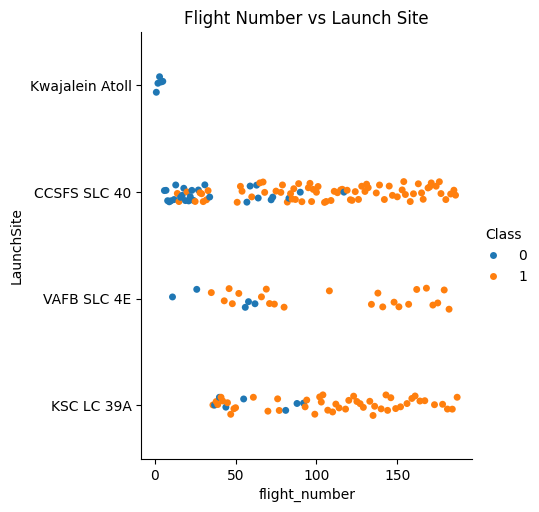

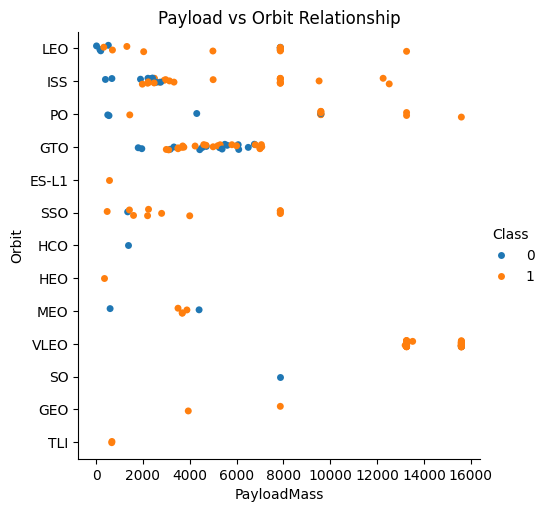

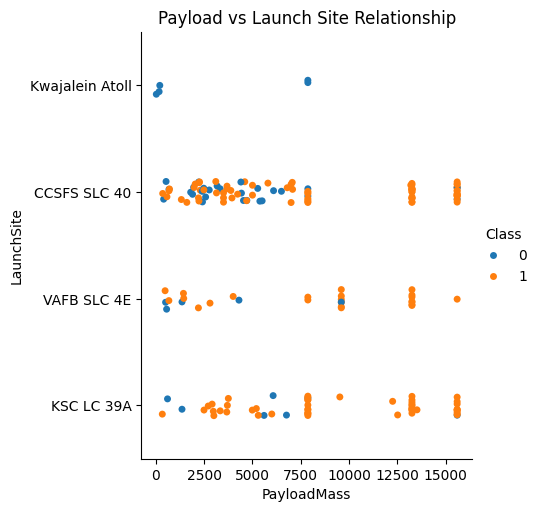

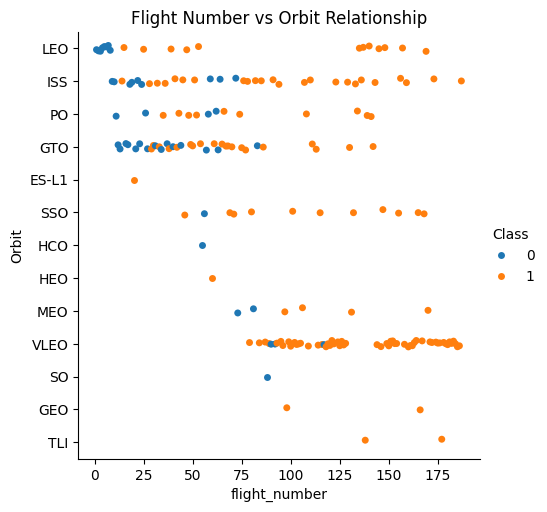

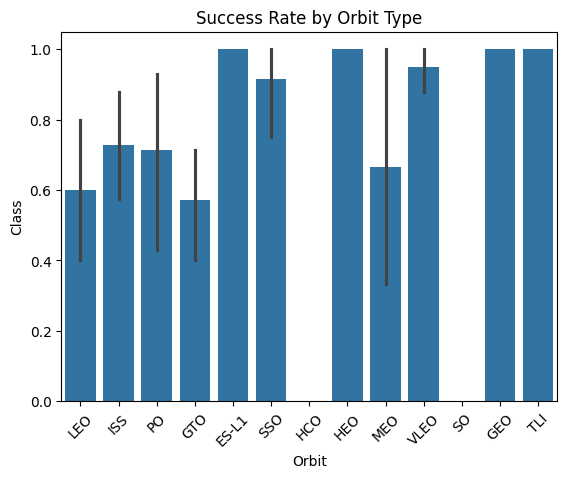

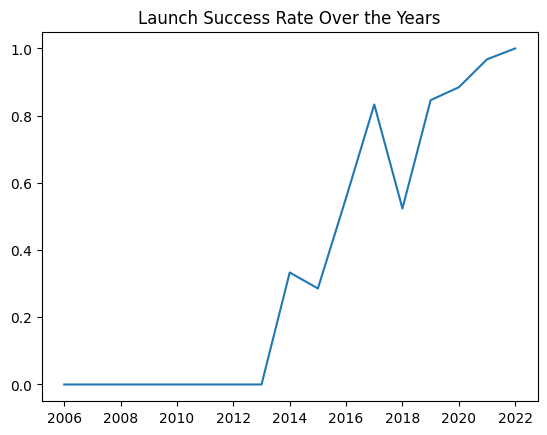

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("dataset_part2.csv")

# Flight Number vs Launch Site
sns.catplot(x="flight_number", y="LaunchSite", hue="Class", data=df)
plt.title("Flight Number vs Launch Site")
plt.show()

# Payload Mass vs Orbit Type
sns.catplot(x="PayloadMass", y="Orbit", hue="Class", data=df)
plt.title("Payload vs Orbit Relationship")
plt.show()

# Payload Mass vs Launch Site
sns.catplot(x="PayloadMass", y="LaunchSite", hue="Class", data=df)
plt.title("Payload vs Launch Site Relationship")
plt.show()

# Flight Number vs Orbit Type
sns.catplot(x="flight_number", y="Orbit", hue="Class", data=df)
plt.title("Flight Number vs Orbit Relationship")
plt.show()

# Success Rate by Orbit
sns.barplot(x=df["Orbit"], y=df["Class"])
plt.xticks(rotation=45)
plt.title("Success Rate by Orbit Type")
plt.show()

# Success Rate by Year
df['Year'] = pd.to_datetime(df['date_utc']).dt.year
yearly_success = df.groupby('Year')['Class'].mean()
plt.plot(yearly_success)
plt.title("Launch Success Rate Over the Years")
plt.show()


# Feature Encoding for ML
features = df[['flight_number','PayloadMass','Orbit','LaunchSite','Block','Reused','Legs','GridFins']]
features = pd.get_dummies(features, columns=['Orbit','LaunchSite'])
features = features.astype('float64')
features.to_csv('dataset_part3.csv', index=False)

In [50]:
import sqlite3
con = sqlite3.connect("spacex.db")
df = pd.read_csv("dataset_part2.csv")
df.to_sql("SPACEXTABLE", con, if_exists="replace", index=False)

# Example Queries
cur = con.cursor()
# 1. Unique Launch Sites
print(cur.execute("SELECT DISTINCT LaunchSite FROM SPACEXTABLE;").fetchall())

# 2. Average Payload per Booster Version
print(cur.execute("SELECT BoosterVersion, AVG(PayloadMass) FROM SPACEXTABLE GROUP BY BoosterVersion;").fetchall())

# 3. First Ground Landing Success
print(cur.execute("SELECT MIN(date_utc) FROM SPACEXTABLE WHERE Outcome LIKE '%True RTLS%';").fetchall())

[('Kwajalein Atoll',), ('CCSFS SLC 40',), ('VAFB SLC 4E',), ('KSC LC 39A',)]
[('Falcon 1', 3224.34950617284), ('Falcon 9', 8085.553891647694), ('Falcon Heavy', 2650.0)]
[('2015-12-22T01:29:00.000Z',)]


In [73]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster

spacex_df = pd.read_csv("dataset_part2.csv")
map_sites = folium.Map(location=[29.559684, -95.083097], zoom_start=5)

marker_cluster = MarkerCluster().add_to(map_sites)
for _, row in spacex_df.iterrows():
    color = 'green' if row['Class'] == 1 else 'red'
    folium.Marker(
        [row['Latitude'], row['Longitude']],
        popup=row['LaunchSite'],
        icon=folium.Icon(color=color)
    ).add_to(marker_cluster)

map_sites.save("spacex_launch_sites.html")

In [52]:
!pip install dash dash-core-components dash-html-components dash-bootstrap-components plotly

In [75]:
from dash import Dash, html, dcc, Input, Output
import pandas as pd
import plotly.express as px

df = pd.read_csv('dataset_part2.csv')

app = Dash(__name__)

app.layout = html.Div([
    html.H1("SpaceX Launch Dashboard"),
    dcc.Dropdown(
        id='site-dropdown',
        options=[{'label': i, 'value': i} for i in df['LaunchSite'].unique()] + [{'label': 'All Sites', 'value': 'ALL'}],
        value='ALL',
    ),
    dcc.Graph(id='success-pie'),
    html.Br(),
    html.P("Payload Range (Kg):"),
    dcc.RangeSlider(id='payload-slider', min=0, max=10000, step=1000, value=[0,10000]),
    dcc.Graph(id='success-payload-scatter'),
    html.Br(),
    dcc.Graph(id='total-success-pie') # New pie chart for total success count
])

@app.callback(
    Output('success-pie', 'figure'),
    Input('site-dropdown', 'value')
)
def update_site_pie(site):
    if site == 'ALL':
        success_by_site = df.groupby('LaunchSite')['Class'].mean().reset_index()
        highest_success_site = success_by_site.loc[success_by_site['Class'].idxmax()]
        title = f'Total Success across Sites (Highest Success: {highest_success_site["LaunchSite"]} with {highest_success_site["Class"]:.2f})'
        fig = px.pie(df, names='LaunchSite', values='Class', title=title)
    else:
        filtered = df[df['LaunchSite'] == site]
        fig = px.pie(filtered, names='Class', title=f'Success Rate for {site}')
    return fig

@app.callback(
    Output('success-payload-scatter', 'figure'),
    [Input('site-dropdown','value'), Input('payload-slider','value')]
)
def update_scatter(site, payload):
    low, high = payload
    filtered = df[(df['PayloadMass'] >= low) & (df['PayloadMass'] <= high)]
    if site != 'ALL':
        filtered = filtered[filtered['LaunchSite'] == site]
    fig = px.scatter(filtered, x='PayloadMass', y='Class', color='Orbit', title='Payload vs Success')
    return fig

@app.callback(
    Output('total-success-pie', 'figure'),
    Input('site-dropdown', 'value') # Although this pie chart is for all sites, we can use the dropdown input to trigger updates if needed
)
def update_total_success_pie(site):
    # Calculate the total count of successful and failed launches
    total_success_counts = df['Class'].value_counts().reset_index()
    total_success_counts.columns = ['Class', 'Count']
    total_success_counts['Class'] = total_success_counts['Class'].map({1: 'Success', 0: 'Failure'})
    fig = px.pie(total_success_counts, values='Count', names='Class', title='Total Launch Success/Failure Count Across All Sites')
    return fig


if __name__ == '__main__':
    app.run(debug=True, port=8051)

<IPython.core.display.Javascript object>

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_csv("dataset_part3.csv")
labels = pd.read_csv("dataset_part2.csv")['Class']

# Impute missing values in the 'Block' column with the mean
data['Block'].fillna(data['Block'].mean(), inplace=True)

X = StandardScaler().fit_transform(data)
Y = labels
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Dictionary to store best estimators and their test scores
best_estimators = {}
test_scores = {}

# Logistic Regression
param_lr = {'C':[0.01,0.1,1], 'solver':['lbfgs']}
logreg_cv = GridSearchCV(LogisticRegression(), param_lr, cv=10)
logreg_cv.fit(X_train, Y_train)
best_estimators['Logistic Regression'] = logreg_cv.best_estimator_
test_scores['Logistic Regression'] = logreg_cv.best_estimator_.score(X_test, Y_test)
print("Best LR params:", logreg_cv.best_params_)
print("LR test score:", test_scores['Logistic Regression'])

# Decision Tree
param_tree = {'max_depth': range(2,10), 'criterion':['gini','entropy']}
tree_cv = GridSearchCV(DecisionTreeClassifier(), param_tree, cv=10)
tree_cv.fit(X_train, Y_train)
best_estimators['Decision Tree'] = tree_cv.best_estimator_
test_scores['Decision Tree'] = tree_cv.best_estimator_.score(X_test, Y_test)
print("Best Tree params:", tree_cv.best_params_)
print("Tree test score:", test_scores['Decision Tree'])

# KNN
param_knn = {'n_neighbors': range(1,10), 'p':[1,2]}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_knn, cv=10)
knn_cv.fit(X_train, Y_train)
best_estimators['KNN'] = knn_cv.best_estimator_
test_scores['KNN'] = knn_cv.best_estimator_.score(X_test, Y_test)
print("Best KNN params:", knn_cv.best_params_)
print("KNN test score:", test_scores['KNN'])

# SVM
param_svm = {'kernel':['linear','rbf','poly'], 'C':[0.1,1,10]}
svm_cv = GridSearchCV(SVC(), param_svm, cv=10)
svm_cv.fit(X_train, Y_train)
best_estimators['SVM'] = svm_cv.best_estimator_
test_scores['SVM'] = svm_cv.best_estimator_.score(X_test, Y_test)
print("Best SVM params:", svm_cv.best_params_)
print("SVM test score:", test_scores['SVM'])

# Naive Bayes
param_nb = {} # Naive Bayes typically doesn't require extensive hyperparameter tuning with GridSearchCV
nb_cv = GridSearchCV(GaussianNB(), param_nb, cv=10)
nb_cv.fit(X_train, Y_train)
best_estimators['Naive Bayes'] = nb_cv.best_estimator_
test_scores['Naive Bayes'] = nb_cv.best_estimator_.score(X_test, Y_test)
print("Best Naive Bayes params:", nb_cv.best_params_)
print("Naive Bayes test score:", test_scores['Naive Bayes'])

# Random Forest
param_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}
rf_cv = GridSearchCV(RandomForestClassifier(), param_rf, cv=10)
rf_cv.fit(X_train, Y_train)
best_estimators['Random Forest'] = rf_cv.best_estimator_
test_scores['Random Forest'] = rf_cv.best_estimator_.score(X_test, Y_test)
print("Best Random Forest params:", rf_cv.best_params_)
print("Random Forest test score:", test_scores['Random Forest'])


# Classification Report
print("\nClassification Report:")
for model_name, estimator in best_estimators.items():
    y_pred = estimator.predict(X_test)
    print(f"\n--- {model_name} ---")
    print(classification_report(Y_test, y_pred))

# Compare Accuracy Scores
print("\nModel Accuracy Comparison:")
for model_name, score in test_scores.items():
    print(f"{model_name}: {score:.4f}")

/tmp/ipython-input-1738927360.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Best LR params: {'C': 0.1, 'solver': 'lbfgs'}
LR test score: 0.8421052631578947
Best Tree params: {'criterion': 'gini', 'max_depth': 2}
Tree test score: 0.868421052631579
Best KNN params: {'n_neighbors': 9, 'p': 1}
KNN test score: 0.8157894736842105
Best SVM params: {'C': 0.1, 'kernel': 'linear'}
SVM test score: 0.868421052631579
Best Naive Bayes params: {}
Naive Bayes test score: 0.6052631578947368
Best Random Forest params: {'max_depth': 10, 'n_estimators': 100}
Random Forest test score: 0.8421052631578947

Classification Report:

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.84      0.96      0.90        28

    accuracy                           0.84        38
   macro avg       0.84      0.73      0.76        38
weighted avg       0.84      0.84      0.83        38


--- Decision Tree ---
              precision    recall  f1-score   support

           0       1.00     

/tmp/ipython-input-457438918.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




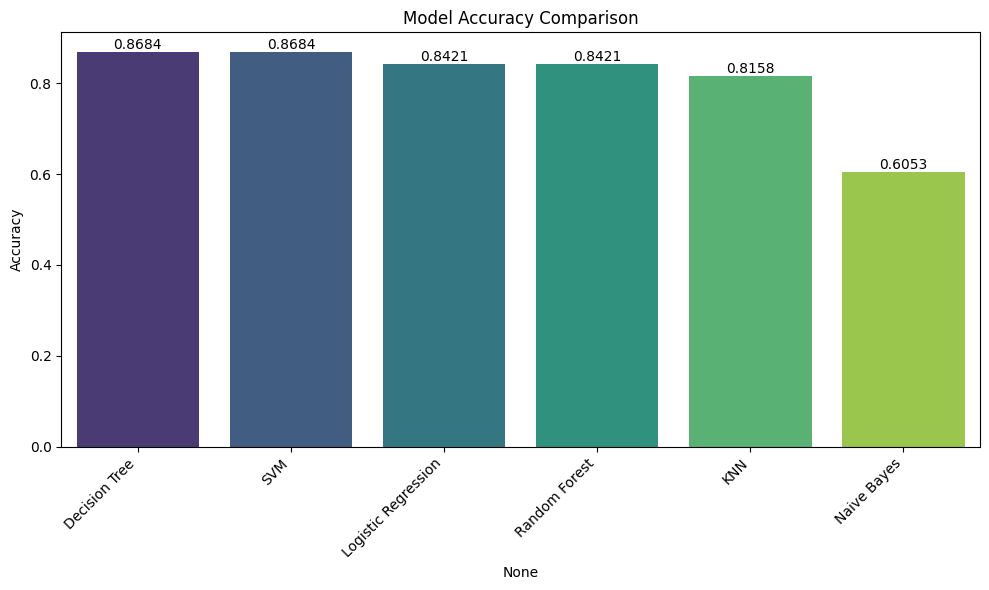

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming test_scores dictionary is available from the previous cell
model_accuracy = pd.Series(test_scores).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=model_accuracy.index, y=model_accuracy.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add accuracy values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

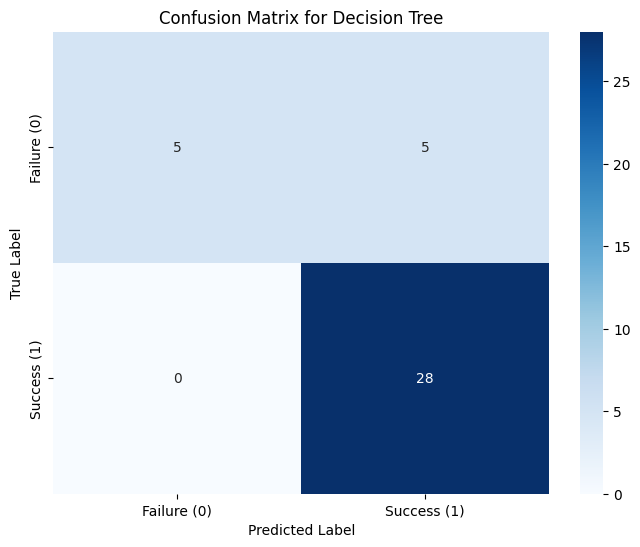

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Find the best performing model based on accuracy
best_model_name = max(test_scores, key=test_scores.get)
best_model = best_estimators[best_model_name]

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Failure (0)', 'Success (1)'], yticklabels=['Failure (0)', 'Success (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [58]:
import sqlite3
import pandas as pd

con = sqlite3.connect("spacex.db")
cur = con.cursor()

# Find the first 5 launch sites which begin with 'CCA'
query = "SELECT LaunchSite FROM SPACEXTABLE WHERE LaunchSite LIKE 'CCA%' LIMIT 5;"
result = cur.execute(query).fetchall()
print(result)

con.close()

[]


In [59]:
import sqlite3
import pandas as pd

con = sqlite3.connect("spacex.db")
cur = con.cursor()

# Find unique launch site names
query = "SELECT DISTINCT LaunchSite FROM SPACEXTABLE;"
result = cur.execute(query).fetchall()
print(result)

con.close()

[('Kwajalein Atoll',), ('CCSFS SLC 40',), ('VAFB SLC 4E',), ('KSC LC 39A',)]


In [61]:
import sqlite3

# Connect to the SQLite database file
conn = sqlite3.connect("spacex.db")
cur = conn.cursor()

# SQL query to sum PayloadMass from launches where PayloadMass is not null
query = """
SELECT SUM(PayloadMass) as TotalPayload
FROM SPACEXTABLE
WHERE PayloadMass IS NOT NULL;
"""

cur.execute(query)
result = cur.fetchone()

total_payload = result[0]
print(f"Total payload mass carried by SpaceX boosters: {total_payload} kg")

# Close the connection
conn.close()


Total payload mass carried by SpaceX boosters: 1471385.8941358016 kg


In [66]:
import sqlite3

con = sqlite3.connect("spacex.db")
cur = con.cursor()

# Find the average payload mass for booster version F9 v1.1
query = "SELECT AVG(PayloadMass) FROM SPACEXTABLE WHERE BoosterVersion = 'F9 v1.1';"
cur.execute(query)
result = cur.fetchone()

average_payload = result[0]
print(f"Average payload mass for F9 v1.1: {average_payload} kg")

con.close()

Average payload mass for F9 v1.1: None kg


In [67]:
import sqlite3

con = sqlite3.connect("spacex.db")
cur = con.cursor()

# Find the date of the first successfully landing outcome on the ground pad
query = "SELECT MIN(date_utc) FROM SPACEXTABLE WHERE Outcome = 'True RTLS';"
cur.execute(query)
result = cur.fetchone()

first_successful_ground_landing = result[0]
print(f"Date of the first successfully landing outcome on the ground pad: {first_successful_ground_landing}")

con.close()

Date of the first successfully landing outcome on the ground pad: 2015-12-22T01:29:00.000Z


In [68]:
import sqlite3

con = sqlite3.connect("spacex.db")
cur = con.cursor()

# List the names of boosters which have successfully landed on drone ship and has payload mass greater than 4000 but less than 6000
query = "SELECT DISTINCT BoosterVersion FROM SPACEXTABLE WHERE Outcome = 'True ASDS' AND PayloadMass > 4000 AND PayloadMass < 6000;"
cur.execute(query)
result = cur.fetchall()

print("Booster versions with successful drone ship landing and payload mass between 4000 and 6000 kg:")
for row in result:
    print(row[0])

con.close()

Booster versions with successful drone ship landing and payload mass between 4000 and 6000 kg:
Falcon 9


In [69]:
import sqlite3

con = sqlite3.connect("spacex.db")
cur = con.cursor()

# Calculate the total number of successful and failure mission outcomes
query = "SELECT Class, COUNT(*) FROM SPACEXTABLE GROUP BY Class;"
cur.execute(query)
results = cur.fetchall()

print("Mission Outcome Counts (0: Failure, 1: Success):")
for row in results:
    print(f"Class: {row[0]}, Count: {row[1]}")

con.close()

Mission Outcome Counts (0: Failure, 1: Success):
Class: 0, Count: 44
Class: 1, Count: 143


In [70]:
import sqlite3

con = sqlite3.connect("spacex.db")
cur = con.cursor()

# Find the maximum payload mass
query_max_payload = "SELECT MAX(PayloadMass) FROM SPACEXTABLE;"
cur.execute(query_max_payload)
max_payload = cur.fetchone()[0]

# Find the booster version(s) that carried the maximum payload mass
query_booster_with_max_payload = f"SELECT DISTINCT BoosterVersion FROM SPACEXTABLE WHERE PayloadMass = {max_payload};"
cur.execute(query_booster_with_max_payload)
boosters_with_max_payload = cur.fetchall()

print(f"Booster version(s) that carried the maximum payload mass ({max_payload} kg):")
for row in boosters_with_max_payload:
    print(row[0])

con.close()

Booster version(s) that carried the maximum payload mass (15600.0 kg):
Falcon 9


In [71]:
import sqlite3

# Connect to the database
con = sqlite3.connect("spacex.db")
cur = con.cursor()

# Query for failed drone ship landings in 2015
query = """
SELECT Outcome, BoosterVersion, LaunchSite
FROM SPACEXTABLE
WHERE Outcome LIKE '%ASDS%'
  AND Outcome NOT LIKE 'True%'
  AND date_utc LIKE '2015%'
"""
cur.execute(query)
results = cur.fetchall()

print("Failed drone ship landings in 2015 with booster version and launch site:")
for row in results:
    print(f"Outcome: {row[0]}, BoosterVersion: {row[1]}, LaunchSite: {row[2]}")

con.close()


Failed drone ship landings in 2015 with booster version and launch site:
Outcome: False ASDS, BoosterVersion: Falcon 9, LaunchSite: CCSFS SLC 40
Outcome: False ASDS, BoosterVersion: Falcon 9, LaunchSite: CCSFS SLC 40
Outcome: None ASDS, BoosterVersion: Falcon 9, LaunchSite: CCSFS SLC 40


In [72]:
import sqlite3

con = sqlite3.connect("spacex.db")
cur = con.cursor()

query = """
SELECT Outcome, COUNT(*) as total
FROM SPACEXTABLE
WHERE date_utc >= '2010-06-04' AND date_utc <= '2017-03-20'
GROUP BY Outcome
ORDER BY total DESC;
"""

cur.execute(query)
results = cur.fetchall()

print("Landing outcomes ranked by count (2010-06-04 to 2017-03-20):")
for row in results:
    print(f"Outcome: {row[0]}, Count: {row[1]}")

con.close()


Landing outcomes ranked by count (2010-06-04 to 2017-03-20):
Outcome: None None, Count: 12
Outcome: True ASDS, Count: 5
Outcome: False ASDS, Count: 5
Outcome: True RTLS, Count: 3
Outcome: True Ocean, Count: 3
Outcome: None ASDS, Count: 2
Outcome: False Ocean, Count: 2
